In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install kaggle


In [5]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
 55% 124M/225M [00:00<00:00, 1.29GB/s]
100% 225M/225M [00:00<00:00, 788MB/s] 


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/flowers-recognition.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [46]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential # Corrected import and capitalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [8]:
#Ye code har folder ke andar kitni flower images hain, wo count karke print karta hai.
dirs = os.listdir('/content/flowers')
for dir in dirs:
  files = os.listdir('/content/flowers/' + dir)
  print(dir + 'Folder has' + str(len(files)) + 'flowers')

tulipFolder has984flowers
daisyFolder has764flowers
dandelionFolder has1052flowers
sunflowerFolder has733flowers
roseFolder has784flowers


In [14]:
base_dir = '/content/flowers'
img_size = 180
batch_size = 32

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed = 123,
    validation_split=0.2,
    subset='training',
    batch_size = batch_size,
    image_size = (img_size, img_size)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed = 123,
    validation_split=0.2,
    subset='training',
    batch_size = batch_size,
    image_size = (img_size, img_size)
)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [16]:
flower_name = train_ds.class_names
print(flower_name)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


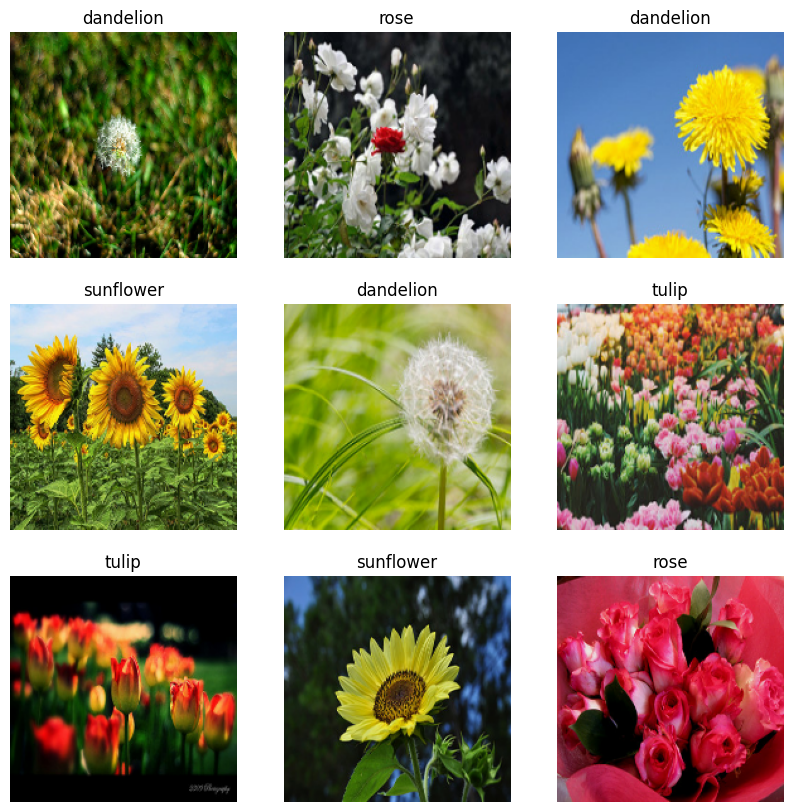

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(flower_name[labels[i]])
    plt.axis('off')


In [27]:
#Ye isliye use hota hai taake model ki training fast, smooth aur efficient ho jaye — bina rukawat ke data load ho, random ho, aur repeat me disk se na aaye.
Autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=Autotune)
val_ds = val_ds.cache().prefetch(buffer_size=Autotune)

In [32]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])


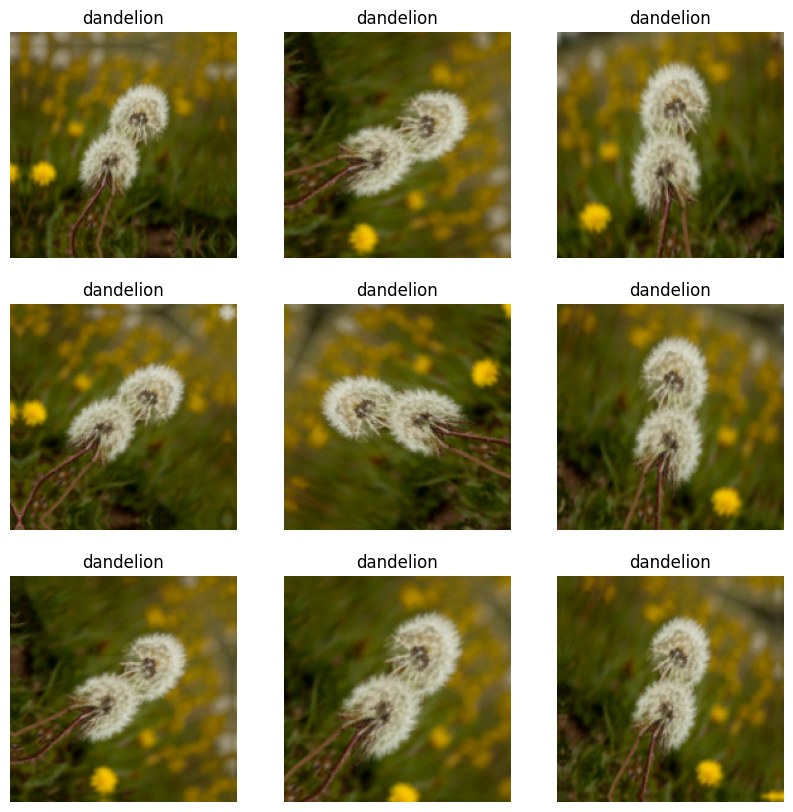

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):       # ek batch le rahe hain
  image = images[0]                            # sirf ek image uthai
  label = labels[0]
  for i in range(9):
    augmented_image = data_augmentation(tf.expand_dims(image, 0))  # 👈 Augment ek hi image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.title(flower_name[label])
    plt.axis('off')
  break  # bas ek hi image ka multiple version dikhana hai


In [47]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7345 - loss: 0.6974 - val_accuracy: 0.6975 - val_loss: 0.7921
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7356 - loss: 0.6996 - val_accuracy: 0.7693 - val_loss: 0.6188
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7414 - loss: 0.6533 - val_accuracy: 0.7684 - val_loss: 0.6171
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7470 - loss: 0.6517 - val_accuracy: 0.7791 - val_loss: 0.5801
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7620 - loss: 0.6350 - val_accuracy: 0.7779 - val_loss: 0.5830
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7477 - loss: 0.6434 - val_accuracy: 0.7869 - val_loss: 0.5475
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7695 - loss: 0.5883 - val_accuracy: 0.7942 - val_loss: 0.5261
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7629 - loss: 0.6096 - val_accu

In [59]:
model.save('flower_model.keras')

In [60]:
!pip install streamlit
!pip install pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 10.7 MB/s eta 0:00:00


In [61]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

flower_name = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

model = tf.keras.models.load_model('/content/flower_model.keras')  # Apna model path do

st.title("🌸 Flower Classification using CNN")

uploaded_file = st.file_uploader("Upload a flower image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    img = image.resize((180, 180))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    predicted_class = flower_name[np.argmax(score)]
    confidence = 100 * np.max(score)

    st.markdown(f"**Predicted Class:** `{predicted_class}`")
    st.markdown(f"**Confidence:** `{confidence:.2f}%`")


Writing app.py


In [65]:
# Step 1: Auth token lagao (pehle se kiya ho to skip kar do)
!ngrok config add-authtoken 2xFzrqv0DqljwNSEL7GTsiExZgz_6nqyZcnsa5agW9kCN5cBj

# Step 2: Streamlit app run karo
!streamlit run /content/app.py &>/content/logs.txt &

# Step 3: Ngrok se tunnel banao
from pyngrok import ngrok

public_url = ngrok.connect(addr="8501")   # ✅ Yahi line important hai
print("🌐 Streamlit App URL:", public_url)


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🌐 Streamlit App URL: NgrokTunnel: "https://ef8b-34-16-200-117.ngrok-free.app" -> "http://localhost:8501"
